<a href="https://colab.research.google.com/github/eletap/ML-Churn-Prediction/blob/main/ML_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install pickle5


In [ ]:
!pip install pandas==1.3.2

In [ ]:
import pandas as pd
import pickle as pickle

print("Loading Data from DataFrames")
pickle.HIGHEST_PROTOCOL = 5

DF1 = pd.read_pickle('drive/MyDrive/ML_Churn_Data/ET_ML_CHURN_FI_FNL')
#X1 = pd.read_pickle('drive/MyDrive/ML_Churn_Data/ET_ML_CHURN_FI_FNL_X')
#Y1 = pd.read_pickle('drive/MyDrive/ML_Churn_Data/ET_ML_CHURN_FI_FNL_Y')
#Z1 = pd.read_pickle('drive/MyDrive/ML_Churn_Data/ET_ML_CHURN_FI_FNL_Z')

DF = DF1.sample(n=300000,  random_state=1)
#X = X1.sample(n=30000,  random_state=1)
#Y = Y1.sample(n=30000,  random_state=1)
#Z = Z1.sample(n=30000,  random_state=1)

X, Z, Y = DF.drop(['SYMB', 'CURRENT_POLICY_STATUS'], axis=1), DF['SYMB'], DF['CURRENT_POLICY_STATUS']


Loading Data from DataFrames


In [ ]:
DF.head()

,ACCEPT_EMAIL,INS_PKG_KEY,AGENT_CTGR_KEY,AGENT_KEY,BONUS_MALUS,CAR_AGE,CAR_BRAND_KEY,CAR_CAPACITY,CAR_INVC_ZONE_KEY,CAR_MODEL_KEY,CAR_PROD_YEAR,CAR_USAGE_KEY,COV1_PREMIUM,COV10_PREMIUM,COV11_PREMIUM,COV12_PREMIUM,COV13_PREMIUM,COV14_PREMIUM,COV15_PREMIUM,COV16_PREMIUM,COV17_PREMIUM,COV18_PREMIUM,COV19_PREMIUM,COV2_PREMIUM,COV20_PREMIUM,COV3_PREMIUM,COV4_PREMIUM,COV5_PREMIUM,COV6_PREMIUM,COV7_PREMIUM,COV8_PREMIUM,COV9_PREMIUM,CURRENT_POLICY_STATUS,CUST_AGE,IS_STANDING_ORDER,LOYALTY_PROGRAM,NUM_ACCIDENTS_INVOLVED,NUM_ACCIDENTS_NOT_RESP,NUM_ACCIDENTS_RESP,NUM_ACCIDENTS_RESP_FR,...,INS_PARTY_TENURE_RANGE_KEY,INS_SYMB_TENURE_RANGE_KEY,INS_ALLPARTY_TENURE_RANGE_KEY,DISC_105,DISC_107,DISC_110,DISC_130,DISC_131,DISC_132,DISC_145,DISC_146,DISC_147,DISC_148,DISC_149,DISC_156,DISC_157,DISC_158,DISC_159,DISC_160,DISC_161,DISC_162,DISC_163,DISC_500,DISC_501,DISC_505,DISC_506,DISC_507,NUM_ACTIVE_INS_SYMB_AFM,LIFE_SYMB_AFM,FIRE_SYMB_AFM,LIFE_SYMB_PARTY,FIRE_SYMB_PARTY,CLAIMS_AMOUNT,MAX_MONTHLY_PREMIUM_PRICE,HAS_RETURNED,NEW_PREMIUM_PRICE,NUM_COMPLAINTS,NEW_MONTHLY_PREMIUM_PRICE,LOSS_RATIO,ASFAL_AMOUNT
0,0,7489,157,144280,-2,13,6576,10,1042,22381,2008,697,0,0.00,0.0,0.0,0.00,0.0,0.00,1.42,0.0,0.0,0,0,0,0.0,0.34,27.79,0.0,0.00,0.0,0.0,0,61,0,0,0,0,0,0,...,4,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,10.38,0,29.55,0,0.0,0.0,60.70
1,1,7316,164,143574,-2,23,5948,9,992,22908,1998,697,0,0.72,0.0,0.0,0.00,0.0,0.00,1.48,0.0,0.0,0,0,0,0.0,0.37,29.17,0.0,0.00,0.0,0.0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,10.58,0,31.74,0,0.0,0.0,63.48
2,0,7489,157,139151,-2,36,6431,9,1042,22893,1985,697,0,0.00,17.9,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0,0,0,0.0,0.00,70.97,0.0,0.00,0.0,0.0,0,70,0,0,0,0,0,0,...,4,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,14.81,1,88.87,0,0.0,0.0,716.49
3,0,7859,164,149660,0,21,6539,90,1042,23627,2000,701,0,0.00,0.0,0.0,3.21,0.0,12.18,0.00,0.0,0.0,0,0,0,0.0,1.05,100.90,0.0,10.63,0.0,0.0,0,0,0,0,0,0,0,0,...,3,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,10.66,1,0.00,0,0.0,0.0,127.97
4,0,7653,164,149423,-2,45,5947,10,1042,23598,1976,690,0,0.95,0.0,0.0,2.85,0.0,0.00,1.60,0.0,0.0,0,0,0,0.0,0.43,23.67,0.0,0.00,0.0,0.0,0,58,0,0,0,0,0,0,...,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,19.97,0,29.50,0,0.0,0.0,661.63


In [ ]:
DF.drop(['NEW_PREMIUM_PRICE', 'NEW_MONTHLY_PREMIUM_PRICE'], axis=1, inplace=True)
X.drop(['NEW_PREMIUM_PRICE', 'NEW_MONTHLY_PREMIUM_PRICE'], axis=1, inplace=True) #removed from training dataset because it has been noted that it is always zero if target class is 0 (if customer has churned)
X.drop(['COV1_PREMIUM','COV2_PREMIUM', 'COV19_PREMIUM', 'COV20_PREMIUM','DISC_105' ], axis=1, inplace=True) #removed because after feature selection methods (Corr.Matrix ) it became evident that they contain null values that were not handled in the ETL (DB) process
DF.drop(['COV1_PREMIUM','COV2_PREMIUM','COV19_PREMIUM', 'COV20_PREMIUM', 'DISC_105'], axis=1, inplace=True) #removed because after feature selection methods (Corr.Matrix ) it became evident that they contain null values that were not handled in the ETL (DB) process


In [ ]:
DF.describe()

,ACCEPT_EMAIL,INS_PKG_KEY,AGENT_CTGR_KEY,AGENT_KEY,BONUS_MALUS,CAR_AGE,CAR_BRAND_KEY,CAR_CAPACITY,CAR_INVC_ZONE_KEY,CAR_MODEL_KEY,CAR_PROD_YEAR,CAR_USAGE_KEY,COV10_PREMIUM,COV11_PREMIUM,COV12_PREMIUM,COV13_PREMIUM,COV14_PREMIUM,COV15_PREMIUM,COV16_PREMIUM,COV17_PREMIUM,COV18_PREMIUM,COV3_PREMIUM,COV4_PREMIUM,COV5_PREMIUM,COV6_PREMIUM,COV7_PREMIUM,COV8_PREMIUM,COV9_PREMIUM,CURRENT_POLICY_STATUS,CUST_AGE,IS_STANDING_ORDER,LOYALTY_PROGRAM,NUM_ACCIDENTS_INVOLVED,NUM_ACCIDENTS_NOT_RESP,NUM_ACCIDENTS_RESP,NUM_ACCIDENTS_RESP_FR,NUM_ACCIDENTS_RESP_NOT_FR,NUM_ACTIVE_SYMB,NUM_COVERAGES,NUM_PARTY_ACTIVE_SYMB,...,PREMIUM_PRICE,SYMB_DURATION,TAXK_INC_ZONE_KEY,INS_PARTY_TENURE_RANGE_KEY,INS_SYMB_TENURE_RANGE_KEY,INS_ALLPARTY_TENURE_RANGE_KEY,DISC_107,DISC_110,DISC_130,DISC_131,DISC_132,DISC_145,DISC_146,DISC_147,DISC_148,DISC_149,DISC_156,DISC_157,DISC_158,DISC_159,DISC_160,DISC_161,DISC_162,DISC_163,DISC_500,DISC_501,DISC_505,DISC_506,DISC_507,NUM_ACTIVE_INS_SYMB_AFM,LIFE_SYMB_AFM,FIRE_SYMB_AFM,LIFE_SYMB_PARTY,FIRE_SYMB_PARTY,CLAIMS_AMOUNT,MAX_MONTHLY_PREMIUM_PRICE,HAS_RETURNED,NUM_COMPLAINTS,LOSS_RATIO,ASFAL_AMOUNT
count,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.00000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,...,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.00000,986261.000000,986261.000000,986261.000000,986261.000000,986261.00000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,9.862610e+05,986261.000000
mean,0.426643,7539.542755,159.836241,146003.920582,-1.533767,16.893964,5919.179955,14.450520,1007.813771,20934.922167,2001.337630,693.705300,1.232724,5.726203,0.494432,1.054706,0.619641,0.199689,0.117608,1.147832,0.567619,0.063329,1.41632,65.475040,-0.308453,4.290011,2.174848,1.870437,0.674379,44.047370,0.010345,0.030478,0.051268,0.013092,0.038298,0.018319,0.020619,1882.224432,9.305768,1882.258488,...,86.141987,5.830765,1958.587309,3.448876,2.119183,1.675147,0.007434,0.002242,0.036165,0.136373,0.000110,0.017565,0.026005,0.013594,0.011023,0.015618,0.006207,0.022442,0.064270,0.163598,0.190844,0.000168,0.000004,0.004642,0.00033,0.000139,0.000002,0.000955,0.000002,0.54373,0.023321,0.174753,0.021058,0.164044,288.950360,15.172092,0.362319,0.000391,7.811036e+01,482.724666
std,0.500433,234.994390,3.706286,5955.100844,1.086612,34.450700,1340.996774,39.779216,34.647751,7337.370620,81.734952,13.174767,1.227099,7.613357,2.893390,2.057896,3.629081,2.160515,0.418880,3.813340,3.061069,1.228108,4.06825,38.809558,3.466598,5.759699,22.003497,8.151397,0.468607,119.612181,0.101184,0.171898,0.243004,0.116601,0.209132,0.140359,0.150553,8208.488004,3.434012,8208.395922,...,63.807109,3.083804,387.327441,1.638725,1.077977,1.169568,0.085900,0.047295,0.186700,0.343184,0.010464,0.131365,0.159151,0.115797,0.104412,0.123991,0.078541,0.148117,0.245233,0.369910,0.392967,0.012972,0.002014,0.067972,0.01815,0.011785,0.001424,0.030890,0.001424,9.52106,0.783331,3.832896,0.301373,1.340140,3793.110227,7.833774,0.480671,0.020335,2.479859e+03,529.188730
min,-1.000000,7087.000000,153.000000,136733.000000,-2.000000,-186.000000,-1.000000,1.000000,938.000000,-1.000000,0.000000,646.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

Method 1: Correlation Coefficient (based on Pearson Correlation)


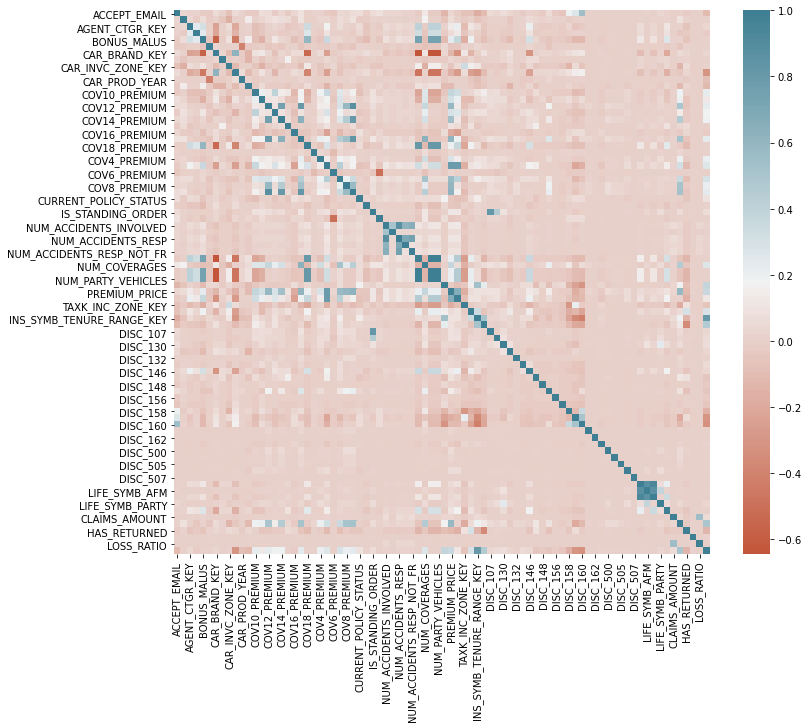

Correlated Features:
 {'CAR_BRAND_KEY - CAR_MODEL_KEY': 0.6281835649999944, 'COV12_PREMIUM - COV14_PREMIUM': 0.7597017793567141, 'COV12_PREMIUM - COV17_PREMIUM': 0.8136148058629915, 'COV14_PREMIUM - COV17_PREMIUM': 0.6537696655851503, 'COV12_PREMIUM - COV9_PREMIUM': 0.8750835884689726, 'COV14_PREMIUM - COV9_PREMIUM': 0.8074042827037178, 'COV17_PREMIUM - COV9_PREMIUM': 0.8321982763105725, 'NUM_ACCIDENTS_INVOLVED - NUM_ACCIDENTS_RESP': 0.878829599917352, 'NUM_ACCIDENTS_INVOLVED - NUM_ACCIDENTS_RESP_FR': 0.6223901290116979, 'NUM_ACCIDENTS_RESP - NUM_ACCIDENTS_RESP_FR': 0.7066260364179009, 'NUM_ACCIDENTS_INVOLVED - NUM_ACCIDENTS_RESP_NOT_FR': 0.6600309023678629, 'NUM_ACCIDENTS_RESP - NUM_ACCIDENTS_RESP_NOT_FR': 0.7525937883801079, 'BONUS_MALUS - NUM_ACTIVE_SYMB': 0.7415450307719695, 'CAR_BRAND_KEY - NUM_ACTIVE_SYMB': 0.6445451086050588, 'COV18_PREMIUM - NUM_ACTIVE_SYMB': 0.8141170972031312, 'COV17_PREMIUM - NUM_COVERAGES': 0.644321687311005, 'BONUS_MALUS - NUM_PARTY_ACTIVE_SYMB': 0.7415560

In [ ]:
#! /usr/bin/python3
#Feature Selection Functions
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# Description: Feature Importance Using Filter Methods (do not incorporate in specific ML algorithm)
# Method 1: Correlation Coefficient (based on Pearson Correlation)
print('Method 1: Correlation Coefficient (based on Pearson Correlation)')
correlation_matrix = DF.corr()  # correlation_matrix = x.corr()
# Plot the Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap=sns.diverging_palette(20, 220, n=200))  # annot=True, fmt="d"
plt.show()
cor_target = abs(correlation_matrix["CURRENT_POLICY_STATUS"])  # correlation with output variable
cor_matrix_importance = cor_target[cor_target >= 0.0]  # selecting highly correlated features
#print('Correlation Coefficient Scores:\n', cor_matrix_importance)  # relevant_features

# Extra investigation regarding correlation between features
correlated_features = {}

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.6:
            colname = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            correlated_features[col2 + ' - ' + colname] = abs(correlation_matrix.iloc[i, j])

print('Correlated Features:\n', correlated_features)


Method 2: Information Gain (Mutual information for a discrete target)


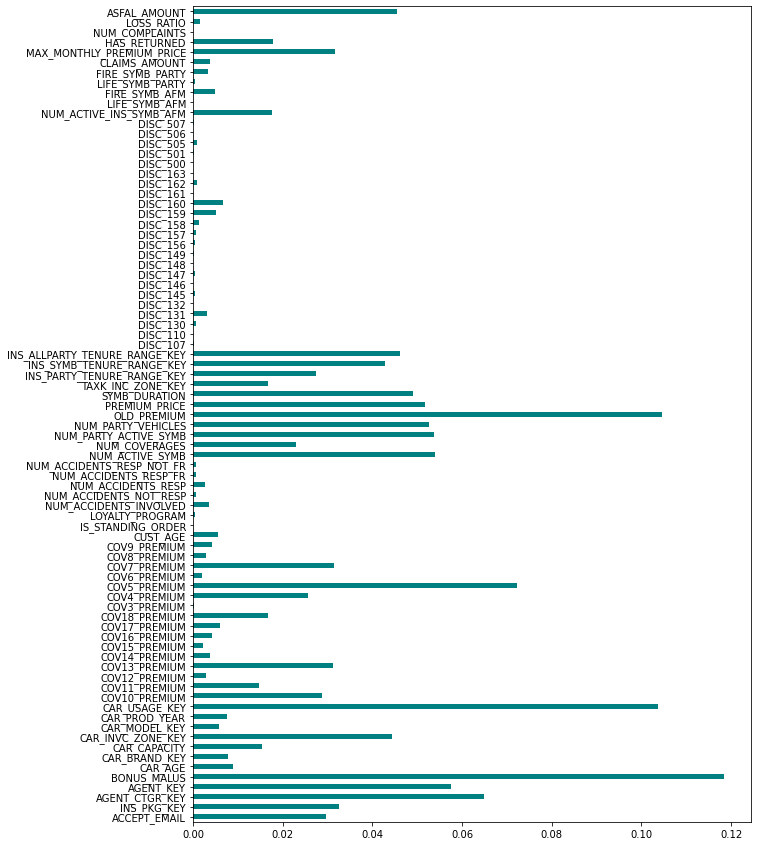

Information Gain Scores:
 ACCEPT_EMAIL                 0.029677
INS_PKG_KEY                  0.032601
AGENT_CTGR_KEY               0.064990
AGENT_KEY                    0.057510
BONUS_MALUS                  0.118477
                               ...   
MAX_MONTHLY_PREMIUM_PRICE    0.031682
HAS_RETURNED                 0.017824
NUM_COMPLAINTS               0.000000
LOSS_RATIO                   0.001579
ASFAL_AMOUNT                 0.045542
Length: 81, dtype: float64


In [ ]:
# Method 2: Information Gain (Mutual information for a discrete target)

print('Method 2: Information Gain (Mutual information for a discrete target)')
mutual_info_cl = mutual_info_classif(X, Y.astype('category'))
mutual_info_importance = pd.Series(mutual_info_cl, X.columns)
# Plot the Information Gain Chart
mutual_info_importance.plot(kind='barh', color='teal', figsize=(10,15))
plt.show()
print('Information Gain Scores:\n', mutual_info_importance)  # relevant_features

Method 3: K Best - ANOVA


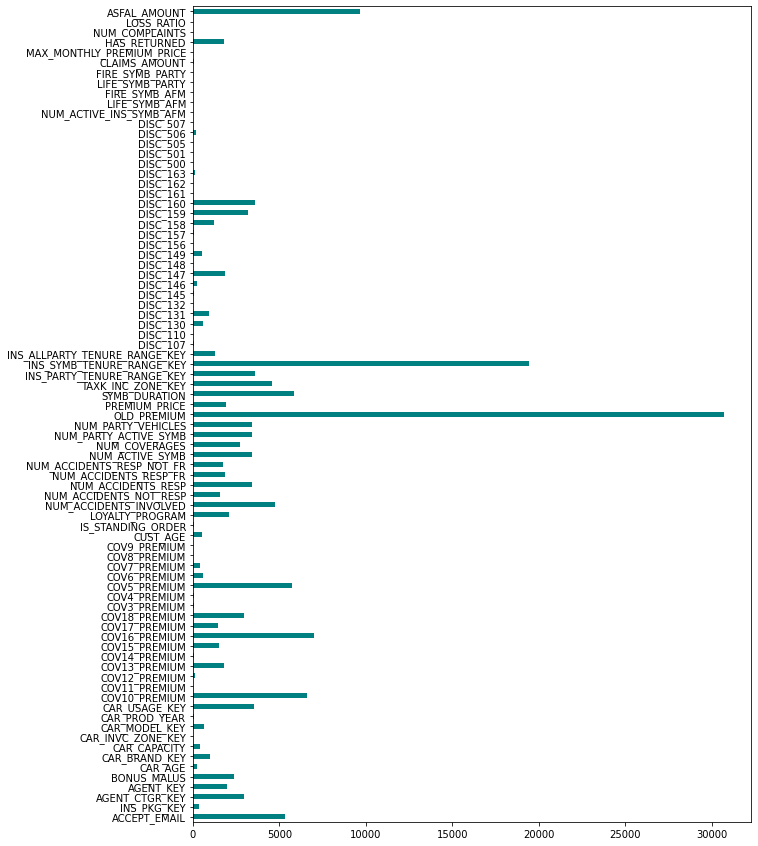

K Best Scores:
 ACCEPT_EMAIL                 5335.838284
INS_PKG_KEY                   350.569578
AGENT_CTGR_KEY               2922.957670
AGENT_KEY                    1987.653214
BONUS_MALUS                  2346.738527
                                ...     
MAX_MONTHLY_PREMIUM_PRICE       3.996009
HAS_RETURNED                 1784.266516
NUM_COMPLAINTS                  1.275870
LOSS_RATIO                      1.394854
ASFAL_AMOUNT                 9630.609638
Length: 81, dtype: float64


In [ ]:
# Method 3: K Best - ANOVA
print('Method 3: K Best - ANOVA')

kbest_selector = SelectKBest(score_func=f_classif, k='all')  # apply SelectKBest class to extract top k best features
kbest_fs = kbest_selector.fit(X, Y)  # apply feature selection fit_transform(x, y)
kbest_importance = pd.Series(np.nan_to_num(kbest_fs.scores_), X.columns)
# Plot the K Best Chart
kbest_importance.plot(kind='barh', color='teal', figsize=(10,15))
plt.show()
print('K Best Scores:\n', kbest_importance)


In [ ]:
import copy

mutual_info_importancedf=mutual_info_importance.to_frame()
kbest_importancedf=kbest_importance.to_frame()
features_scores = pd.concat([mutual_info_importancedf, kbest_importancedf], axis=1)
features_scores.columns=['InfoGain', 'Kbest']
features_scores['CombScore']= features_scores['InfoGain']*features_scores['Kbest']
i=0
final_feature_list=[]
for index, row in features_scores.sort_values(by=['CombScore', 'Kbest', 'InfoGain'], ascending=False).iterrows():
    i+=1
    if i>15:
        break
    final_feature_list.append(index)

col_to_remove=[]
for col in list(X.columns):
  if col not in final_feature_list:
    #print('Droping column:', col)
    col_to_remove.append(col)
X.drop(col_to_remove, axis=1, inplace=True)
print('Final features: ',list(X.columns))
X.head()

Final features:  ['ACCEPT_EMAIL', 'AGENT_CTGR_KEY', 'AGENT_KEY', 'BONUS_MALUS', 'CAR_USAGE_KEY', 'COV10_PREMIUM', 'COV5_PREMIUM', 'NUM_ACTIVE_SYMB', 'NUM_PARTY_ACTIVE_SYMB', 'NUM_PARTY_VEHICLES', 'OLD_PREMIUM', 'PREMIUM_PRICE', 'SYMB_DURATION', 'INS_SYMB_TENURE_RANGE_KEY', 'ASFAL_AMOUNT']


,ACCEPT_EMAIL,AGENT_CTGR_KEY,AGENT_KEY,BONUS_MALUS,CAR_USAGE_KEY,COV10_PREMIUM,COV5_PREMIUM,NUM_ACTIVE_SYMB,NUM_PARTY_ACTIVE_SYMB,NUM_PARTY_VEHICLES,OLD_PREMIUM,PREMIUM_PRICE,SYMB_DURATION,INS_SYMB_TENURE_RANGE_KEY,ASFAL_AMOUNT
0,0,157,144280,-2,697,0.00,27.79,2,2,2,1,29.55,3,1,60.70
1,1,164,143574,-2,697,0.72,29.17,1,1,1,1,31.74,3,1,63.48
2,0,157,139151,-2,697,0.00,70.97,1,1,1,1,88.87,6,3,716.49
3,0,164,149660,0,701,0.00,100.90,26,41,41,0,127.97,12,1,127.97
4,0,164,149423,-2,690,0.95,23.67,1,1,1,1,29.50,3,4,661.63


In [ ]:
final_feature_list.append('SYMB')
final_feature_list.append('CURRENT_POLICY_STATUS')
#Since our data contain monthly snapshots of contracts, some records might repeat themselves, even for the important features that we kept. So remove duplicates and keep last versions of records.
DF.drop_duplicates(subset=final_feature_list, keep='last', inplace=False)
FX, FZ, FY = DF.drop(['SYMB', 'CURRENT_POLICY_STATUS'], axis=1), DF['SYMB'], DF['CURRENT_POLICY_STATUS']

In [ ]:
DF.describe()

,ACCEPT_EMAIL,INS_PKG_KEY,AGENT_CTGR_KEY,AGENT_KEY,BONUS_MALUS,CAR_AGE,CAR_BRAND_KEY,CAR_CAPACITY,CAR_INVC_ZONE_KEY,CAR_MODEL_KEY,CAR_PROD_YEAR,CAR_USAGE_KEY,COV10_PREMIUM,COV11_PREMIUM,COV12_PREMIUM,COV13_PREMIUM,COV14_PREMIUM,COV15_PREMIUM,COV16_PREMIUM,COV17_PREMIUM,COV18_PREMIUM,COV3_PREMIUM,COV4_PREMIUM,COV5_PREMIUM,COV6_PREMIUM,COV7_PREMIUM,COV8_PREMIUM,COV9_PREMIUM,CURRENT_POLICY_STATUS,CUST_AGE,IS_STANDING_ORDER,LOYALTY_PROGRAM,NUM_ACCIDENTS_INVOLVED,NUM_ACCIDENTS_NOT_RESP,NUM_ACCIDENTS_RESP,NUM_ACCIDENTS_RESP_FR,NUM_ACCIDENTS_RESP_NOT_FR,NUM_ACTIVE_SYMB,NUM_COVERAGES,NUM_PARTY_ACTIVE_SYMB,...,PREMIUM_PRICE,SYMB_DURATION,TAXK_INC_ZONE_KEY,INS_PARTY_TENURE_RANGE_KEY,INS_SYMB_TENURE_RANGE_KEY,INS_ALLPARTY_TENURE_RANGE_KEY,DISC_107,DISC_110,DISC_130,DISC_131,DISC_132,DISC_145,DISC_146,DISC_147,DISC_148,DISC_149,DISC_156,DISC_157,DISC_158,DISC_159,DISC_160,DISC_161,DISC_162,DISC_163,DISC_500,DISC_501,DISC_505,DISC_506,DISC_507,NUM_ACTIVE_INS_SYMB_AFM,LIFE_SYMB_AFM,FIRE_SYMB_AFM,LIFE_SYMB_PARTY,FIRE_SYMB_PARTY,CLAIMS_AMOUNT,MAX_MONTHLY_PREMIUM_PRICE,HAS_RETURNED,NUM_COMPLAINTS,LOSS_RATIO,ASFAL_AMOUNT
count,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.00000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,...,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.00000,986261.000000,986261.000000,986261.000000,986261.000000,986261.00000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,986261.000000,9.862610e+05,986261.000000
mean,0.426643,7539.542755,159.836241,146003.920582,-1.533767,16.893964,5919.179955,14.450520,1007.813771,20934.922167,2001.337630,693.705300,1.232724,5.726203,0.494432,1.054706,0.619641,0.199689,0.117608,1.147832,0.567619,0.063329,1.41632,65.475040,-0.308453,4.290011,2.174848,1.870437,0.674379,44.047370,0.010345,0.030478,0.051268,0.013092,0.038298,0.018319,0.020619,1882.224432,9.305768,1882.258488,...,86.141987,5.830765,1958.587309,3.448876,2.119183,1.675147,0.007434,0.002242,0.036165,0.136373,0.000110,0.017565,0.026005,0.013594,0.011023,0.015618,0.006207,0.022442,0.064270,0.163598,0.190844,0.000168,0.000004,0.004642,0.00033,0.000139,0.000002,0.000955,0.000002,0.54373,0.023321,0.174753,0.021058,0.164044,288.950360,15.172092,0.362319,0.000391,7.811036e+01,482.724666
std,0.500433,234.994390,3.706286,5955.100844,1.086612,34.450700,1340.996774,39.779216,34.647751,7337.370620,81.734952,13.174767,1.227099,7.613357,2.893390,2.057896,3.629081,2.160515,0.418880,3.813340,3.061069,1.228108,4.06825,38.809558,3.466598,5.759699,22.003497,8.151397,0.468607,119.612181,0.101184,0.171898,0.243004,0.116601,0.209132,0.140359,0.150553,8208.488004,3.434012,8208.395922,...,63.807109,3.083804,387.327441,1.638725,1.077977,1.169568,0.085900,0.047295,0.186700,0.343184,0.010464,0.131365,0.159151,0.115797,0.104412,0.123991,0.078541,0.148117,0.245233,0.369910,0.392967,0.012972,0.002014,0.067972,0.01815,0.011785,0.001424,0.030890,0.001424,9.52106,0.783331,3.832896,0.301373,1.340140,3793.110227,7.833774,0.480671,0.020335,2.479859e+03,529.188730
min,-1.000000,7087.000000,153.000000,136733.000000,-2.000000,-186.000000,-1.000000,1.000000,938.000000,-1.000000,0.000000,646.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [ ]:
from sklearn.feature_selection import RFE

def feature_wrapping(scenario, model, x, y):
    # Description: Feature Importance Using RFE Wrapper Method (specific ML algorithm)
    # args: (scenario -> Model_A/Model_B, model-> best model, x-> x_train, y-> y_train)
    
    # create the RFE model, evaluate a subset of attributes and select most important attributes
    rfe = RFE(model)
    rfe = rfe.fit(x, y)
    print('All Columns:', x.columns)
    
    # summarize the selection of the attributes
    print("Num Of Selected Features: %d" % rfe.n_features_)  # the number of features that have been selected
    print("Selected Features: %s" % rfe.support_)  # an array that indicates whether or not a feature was selected
    print("Feature Ranking: %s" % rfe.ranking_)  # the ranking of the features
    feature_index = rfe.get_support(True).tolist()
    rfe_features = list(x.iloc[:, feature_index].columns)

    for i in range(x.shape[1]):
        print('Column: %d, Name: %s, Selected: %s, Rank: %.3f' % (i, x.columns[i], rfe.support_[i],rfe.ranking_[i]))
    
    print('Selected RFE Features:\n', rfe_features)
    rfe_importance = pd.Series(np.nan_to_num(rfe.ranking_), x.columns)
    print('Selected RFE Importance:', rfe_importance)

    return rfe_features

In [ ]:
import numpy as np
import pandas as pd
import pickle5 as pickle
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")



# Description: Algorithm Comparison Based On Accuracy, Precision, Recall, F1-Score using k_folds
print('Starting algorithm_comparison')

# prepare models
models = [
    ('LRB', LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=600, n_jobs=-1))
    ,('LR', LogisticRegression(solver='liblinear', max_iter=600, n_jobs=-1))
    ,('LDA', LinearDiscriminantAnalysis())
    ,('RF', RandomForestClassifier(bootstrap=False, n_estimators=200))
    ,('DTC', DecisionTreeClassifier())
    #,('NB', GaussianNB()),
    #,('SVM', SVC(gamma='auto', probability=True)),
    #,('KNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=7, metric='braycurtis', weights='distance'))
]

scoring = {'accuracy': make_scorer(accuracy_score),
            'balanced_accuracy': make_scorer(balanced_accuracy_score),
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'f1_score': make_scorer(f1_score)
            #,'cohen_kappa_score': make_scorer(cohen_kappa_score),
            ,'roc_auc_score': make_scorer(roc_auc_score)
            }

dictionary = {}
best_models = {}


#x=X.to_numpy()
#y=Y.to_numpy()
# evaluate each model in turn
final_dict={}
for name, model in models:
    scores_dictionary = {}
    kfold = model_selection.KFold(n_splits=5, random_state=np.random.randint(100), shuffle=True)

    for metric, fun in scoring.items():
        cv_results = model_selection.cross_val_score(estimator=model, X=X, y=Y, cv=kfold,scoring=scoring.get(metric))
        scores_dictionary[metric] = cv_results.mean()  # stores mean score for each metric
        # print('cv results', metric, '->', cv_results)
    print('Algorithm:', name, '->', scores_dictionary)
    dictionary[model] = scores_dictionary # {RF:{accuracy:0.8, precision:0.1...}}
    best_models[model] = scores_dictionary['balanced_accuracy']  # {RF: 0.8,...}
    final_dict[name] = scores_dictionary
    # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())

finalDF=pd.DataFrame.from_dict(final_dict, orient='index')
#print(dictionary)
#print(best_models)

# choose the best two models of the ordered dictionary
best_models = OrderedDict(sorted(best_models.items(), key=lambda item: item[1], reverse=True))
model_a = best_models.popitem(last=False)[0]  # get the best model
model_b = best_models.popitem(last=False)[0]  # get the second best model
model_c = best_models.popitem(last=False)[0]  # get the third best model
model_scores = {model_a: dictionary.get(model_a), model_b: dictionary.get(model_b), model_c: dictionary.get(model_c)}  # keep model scores
print('Model_a:', model_a, 'Model_b:', model_b, 'Model_c:', model_c)
best_models = {'Model_A': model_a, 
               'Model_B': model_b, 
               'Model_C': model_c}

    

Starting algorithm_comparison




---



In [ ]:
finalDF.head()

In [ ]:
final_features_to_remove_model=[]
for model in [model_a, model_b, model_c]:
    scores = model_scores.get(model)  # get scores dict for each model
    model_params=model.get_params()
    scenario, = [key for (key, value) in best_models.items() if value == model]
    print('Scenario:', scenario)
    print('Model:', model)
    #print('Model Params:', model_params)

    # Feature Selection (Wrapper method)
    print('Training - ' + scenario + ' Feature Wrapping')
    features = feature_wrapping(scenario, model, X, Y)
    ctrm=[]
    for col in list(X.columns):
      if col not in features:
        ctrm.append(col)
    final_features_to_remove_model.append(ctrm)
    fx=(X.drop(ctrm, axis=1)).to_numpy()
    # Model Finalization
    print( 'Training - ' + scenario + ' Train Finalization')
    # Description: Fit the final classification model on training set
    model.fit(fx, Y)
    # save the model to disk
    filename = scenario + '.sav'
    pickle.dump(model, open(filename, 'wb'))


In [ ]:
# Model Predictions

DFP1 = pd.read_pickle('drive/MyDrive/ML_Churn_Data/ET_ML_CHURN_FI_TEST')
XP1 = pd.read_pickle('drive/MyDrive/ML_Churn_Data/ET_ML_CHURN_FI_TEST_X')
YP1 = pd.read_pickle('drive/MyDrive/ML_Churn_Data/ET_ML_CHURN_FI_TEST_Y')
IDP1 = pd.read_pickle('drive/MyDrive/ML_Churn_Data/ET_ML_CHURN_FI_TEST_Z')


DFP = DFP1.sample(n=3000, random_state=1)
XP = XP1.sample(n=3000, random_state=1)
YP = YP1.sample(n=3000, random_state=1)
IDP = IDP1.sample(n=3000, random_state=1)



In [ ]:
DFP.drop(['NEW_PREMIUM_PRICE', 'NEW_MONTHLY_PREMIUM_PRICE'], axis=1, inplace=True)
XP.drop(['NEW_PREMIUM_PRICE', 'NEW_MONTHLY_PREMIUM_PRICE'], axis=1, inplace=True)
XP.drop(['COV2_PREMIUM', 'COV19_PREMIUM', 'COV20_PREMIUM','DISC_105' ], axis=1, inplace=True) #removed because after feature selection methods (Corr.Matrix ) it became evident that they contain null values that were not handled in the ETL (DB) process
DFP.drop(['COV2_PREMIUM','COV19_PREMIUM', 'COV20_PREMIUM', 'DISC_105'], axis=1, inplace=True) #removed because after feature selection methods (Corr.Matrix ) it became evident that they contain null values that were not handled in the ETL (DB) process


In [ ]:
DFP.head()

In [ ]:
print(col_to_remove)
XP.drop(col_to_remove, axis=1, inplace=True)

XP.head()

In [ ]:
def make_predictions(model, x, symb):
    # convert df to numpy array
    X = x.to_numpy()
    xid = symb.to_numpy()
    # make predictions and probabilities
    predictions = model.predict(X)
    predictions_prob = model.predict_proba(X)

    # show the inputs and predicted outputs
    #for i in range(len(X)):
    #    print("X=%s, Predicted=%s, Predicted Prob=%s" % (xid[i], predictions[i], predictions_prob[i]))

    return xid, predictions, predictions_prob

In [ ]:
#! /usr/bin/python3
import datetime
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

i=-1
for model_name in ['Model_A.sav', 'Model_B.sav', 'Model_C.sav']:
    i+=1
    print('Model Prediction for: ', model_name)

    # Load Stored Models
    model = pickle.load(open(model_name, 'rb'))


    # Make New Predictions
    #print(final_features_to_remove_model[i])
    
    xid, predictions, predictions_prob = make_predictions(model, XP.drop(final_features_to_remove_model[i], axis=1), IDP)
    #print('xid is: ', type(xid), ' with value: ', xid)
    #print('predictions is: ', type(predictions), ' with value: ', predictions)
    #print('predictions_prob is: ', type(predictions_prob), ' with value: ', predictions_prob)

    # Printing the precision and recall, among other metrics
    print(metrics.classification_report(YP, predictions))
    cm = confusion_matrix(YP, predictions)
    #print(cm)
    # Normalized confusion matrix
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
    fig, ax = plt.subplots(figsize=(10, 10))

    #sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['CHURN', 'CHURN'],
    #            yticklabels=['NOT CHURN', 'CHURN'])
    sns.heatmap(cmn, annot=True, fmt='.2f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
